# How to obtain an OAuth refresh token

## Create an integration

To create an integration follow the instructions at https://developer.webex.com/authentication.html.

You need to define an icon for every integration you create. You can either upload an icon or use one of the predefined icons.

Copy the parameters for your integration to below code. 

**The client_secret will only be shown once!**

In this demo we are using an non-existing redirect URI so that the OAuth flow will stall at the point where the browser finally tries to access the redirect URI.

The example code tries to read the client secret from an environment variable `SPARK_CLIENT_SECRET` first, so that i don't have to share my client secret publicly :-)


In [1]:
import os

client_id = 'C7c2beddad408126189a9fb2aefacbb2ae26f2a271b02547419e0b26f48cccbda'
redirect_uri = 'https://foo.example.com'
client_secret = os.environ.get('SPARK_CLIENT_SECRET')

if client_secret is None:
    client_secret = '<insert your client secret here>'


# these are the scopes we will be requesting!
scopes = 'spark:all spark:kms'

## Initiate the OAuth grant flow

The refresh token would typically be requested by an integration running on some web server. On user request the integration to achieve authorization initiates the OAuth flow by redirecting the user's browser to a specific authorization URL. 

Since we don't have a real web service available in this case we have to manually initiate the authorization flow by pointing a web browser to the authorization URL.

Then you want to point your browser to the URL given as *OAuth Authorization URL*. Make sure to append a **state** parameter. Here's an example:
> https://api.ciscospark.com/v1/authorize?client_id=C7c2beddad408126189a9fb2aefacbb2ae26f2a271b02547419e0b26f48cccbda&response_type=code&redirect_uri=https%3A%2F%2Ffoo.example.com&scope=spark%3Aall%20spark%3Akms&state=abc

The **state** parameter will be passed back at the final step of the OAuth flow in the GET to the *redirect URI* so that the integration corelate the authorization result with the request.

When the user's browser is pointed at above URL (either directly as in our test or through redirection from the integration's website) the authorization service will first ask for the user's email address and then authenticate the user. The authentication can be username and password based or through SAML 2.0 SSO if the Spark organization the user is a member of is enabled for SSO.

After successful authentication the user is then prompted to authorize the Integration to use the requested scopes.  

Finally after successful authentication and authorization the user's web browser is then redirected to the redirect URL configured for the integration. In this redirection step the OAuth authorization code is passed as parameter back to the redirect URL together with the **state** parameter passed in the initial request URL which initiated the OAuth flow.

Above URL can also be derived based on *client_id*, *client_secret*, *redirect_uri* and *scopes*. For this we need the help of a Python module called *urllib.parse*. The documentation for this module is available at:
https://docs.python.org/3/library/urllib.parse.html

We specifically use the [`urllib.parse.urlencode()`](https://docs.python.org/3/library/urllib.parse.html#urllib.parse.urlencode) method to create a query string.

In [2]:
# we need the help from an external Python libraries
import urllib.parse
import uuid

base_url = 'https://api.ciscospark.com/v1/authorize'

state = str(uuid.uuid4())   # some random UUID
print('State: {}'.format(state))

# prepare a dictionary with all parameters we need to encode in the URL
data = {
    'client_id' : client_id,
    'response_type' : 'code',
    'redirect_uri' : redirect_uri,
    'scope' : scopes,
    'state' : state
}

# this gets us a url encoded query string
query = urllib.parse.urlencode(data, quote_via=urllib.parse.quote)

# .. which we then finally combine with the base url
url = '{}?{}'.format(base_url, query)
print(url)


State: e06f7890-ed65-46d6-870b-f2cf6cfee955
https://api.ciscospark.com/v1/authorize?client_id=C7c2beddad408126189a9fb2aefacbb2ae26f2a271b02547419e0b26f48cccbda&response_type=code&redirect_uri=https%3A%2F%2Ffoo.example.com&scope=spark%3Aall%20spark%3Akms&state=e06f7890-ed65-46d6-870b-f2cf6cfee955


## Exchange *code* for a refresh token
Since we defined an non-existant redirect URL the browser fails to follow the final redirect in the OAuth authorization flow. In reality the redirect URL would point to the webservice which initiated the authorization flow. Encoded in the URL is the *code* parameter which the web service would exchange for an OAuth refresh token.

The next step now is to extract the OAuth authorization code from the URL and then exchange that code for an OAuth access token. These are the final steps in an OAuth authorization code grant flow and in "real life" these steps would be executed by the integration web service. 

Instead in our test environment this involves manual intervention.

Paste the address from your webbrowser into the last_redirect variable in below code. The code then extracts the *code* from the URL.

In [3]:
last_redirect = 'https://foo.example.com/?code=MGYwNzdhMmEtMDdjZC00MmI5LWFkYTQtZDQxYTJlM2E5ZmRjNTkwZTg1YzAtNzJh&state=e06f7890-ed65-46d6-870b-f2cf6cfee955'

# 1st we parse the URL. We are only interested in the query string
query = urllib.parse.urlparse(last_redirect).query

# then we parse the query string and get a dictionary with key/value pairs
query = urllib.parse.parse_qs(query)

# from that dictionary we finally extract the code
code = query['code'][0]
state = query['state'][0]

print('Code: {}'.format(code))
print('State (same as in the request above!): {}'.format(state))

Code: MGYwNzdhMmEtMDdjZC00MmI5LWFkYTQtZDQxYTJlM2E5ZmRjNTkwZTg1YzAtNzJh
State (same as in the request above!): e06f7890-ed65-46d6-870b-f2cf6cfee955


With that **`code`** the web service (in our case that again is a manual process) can now get a refresh token by exchanging the **`code`** for a token. The **`code`** can only be used **once**.

To authorize the request to exchange the **`code`** for a refresh token the integration has to include the **`client_secret`** in the request. This is the only time the **`client_secret`** is used.

This is done by executing a POST agains a well-known web service as documented here: https://developer.ciscospark.com/authentication.html

In [4]:
import requests
import json

access_token_url = 'https://api.ciscospark.com/v1/access_token'

params = {
    'grant_type' : 'authorization_code',
    'client_id' : client_id,
    'client_secret' : client_secret,
    'code' : code,
    'redirect_uri' : redirect_uri
}

r = requests.post(access_token_url, json = params).json()

print('JSON response:')
print(json.dumps(r, indent=4))

if r.get('errors'):
    error = r['errors'][0]
    print('Failed to get access token: {}'.format(error['description']))
else:
    access_token = r['access_token']
    refresh_token = r['refresh_token']
    
    print('\nAccess token: {}'.format(access_token))
    print('Valid for {} days'.format(round(r['expires_in'] / 60 / 60 / 24)))
    print('Refresh token: {}'.format(refresh_token))
    print('Valid for {} days'.format(round(r['refresh_token_expires_in'] / 60 / 60 / 24)))
    


JSON response:
{
    "access_token": "MzkxYmVjNTgtODFjZC00ODcxLThiMjgtZjA4ZjFjZjYwNWYxYjhiMmZiM2ItZGEw",
    "expires_in": 1209599,
    "refresh_token": "ZjdlNmNjNjUtMGQ1Ni00M2QxLTg4ZDEtZDEwYTY4OTY4ZGU5YWM1YzRmMTMtZjk4",
    "refresh_token_expires_in": 7775999
}

Access token: MzkxYmVjNTgtODFjZC00ODcxLThiMjgtZjA4ZjFjZjYwNWYxYjhiMmZiM2ItZGEw
Valid for 14 days
Refresh token: ZjdlNmNjNjUtMGQ1Ni00M2QxLTg4ZDEtZDEwYTY4OTY4ZGU5YWM1YzRmMTMtZjk4
Valid for 90 days


## Create access tokens using the refresh token
The refresh token can be used to always obtain a new access token. The web service is the same that we used above in the final step of the OAuth flow to exchange the *code* for an access token only with different parameters.


In [5]:
import requests
import json

# web service URL
access_token_url = 'https://api.ciscospark.com/v1/access_token'

# parameters for the API call
params = {
    'grant_type' : 'refresh_token',
    'client_id' : client_id,
    'client_secret' : client_secret,
    'refresh_token' : refresh_token
}

# POST
r = requests.post(access_token_url, json = params)

# the result is JSON
r = r.json()

print('JSON response:')
print(json.dumps(r, indent=4))

# check for errors
if r.get('errors'):
    error = r['errors'][0]
    print('Failed to get access token: {}'.format(error['description']))
else:
    access_token = r['access_token']
    refresh_token = r['refresh_token']
    
    print('\nAccess token: {}'.format(access_token))
    print('Valid for {} days'.format(round(r['expires_in'] / 60 / 60 / 24)))
    print('Refresh token: {}'.format(refresh_token))
    print('Valid for {} days'.format(round(r['refresh_token_expires_in'] / 60 / 60 / 24)))


JSON response:
{
    "access_token": "OTc4MmVlNTYtZmY0YS00YzUyLTk1Y2MtNjFlNzk2ZThjZGIxMjE1YzE2ZjAtNjJk",
    "expires_in": 1209599,
    "refresh_token": "ZjdlNmNjNjUtMGQ1Ni00M2QxLTg4ZDEtZDEwYTY4OTY4ZGU5YWM1YzRmMTMtZjk4",
    "refresh_token_expires_in": 7775997
}

Access token: OTc4MmVlNTYtZmY0YS00YzUyLTk1Y2MtNjFlNzk2ZThjZGIxMjE1YzE2ZjAtNjJk
Valid for 14 days
Refresh token: ZjdlNmNjNjUtMGQ1Ni00M2QxLTg4ZDEtZDEwYTY4OTY4ZGU5YWM1YzRmMTMtZjk4
Valid for 90 days


# Obtaining an OAuth access token directly

An OAuth access token can also be obtained directly from the [Webex Developer Portal](https://developer.webex.com). To obtain a token go to [the portal](https://developer.webex.com) and login. Then you need to navigate to **Docs**. This opens the "Getting Started" page. On that page in the "Authentication" section the personal (or portal) token is displayed. 

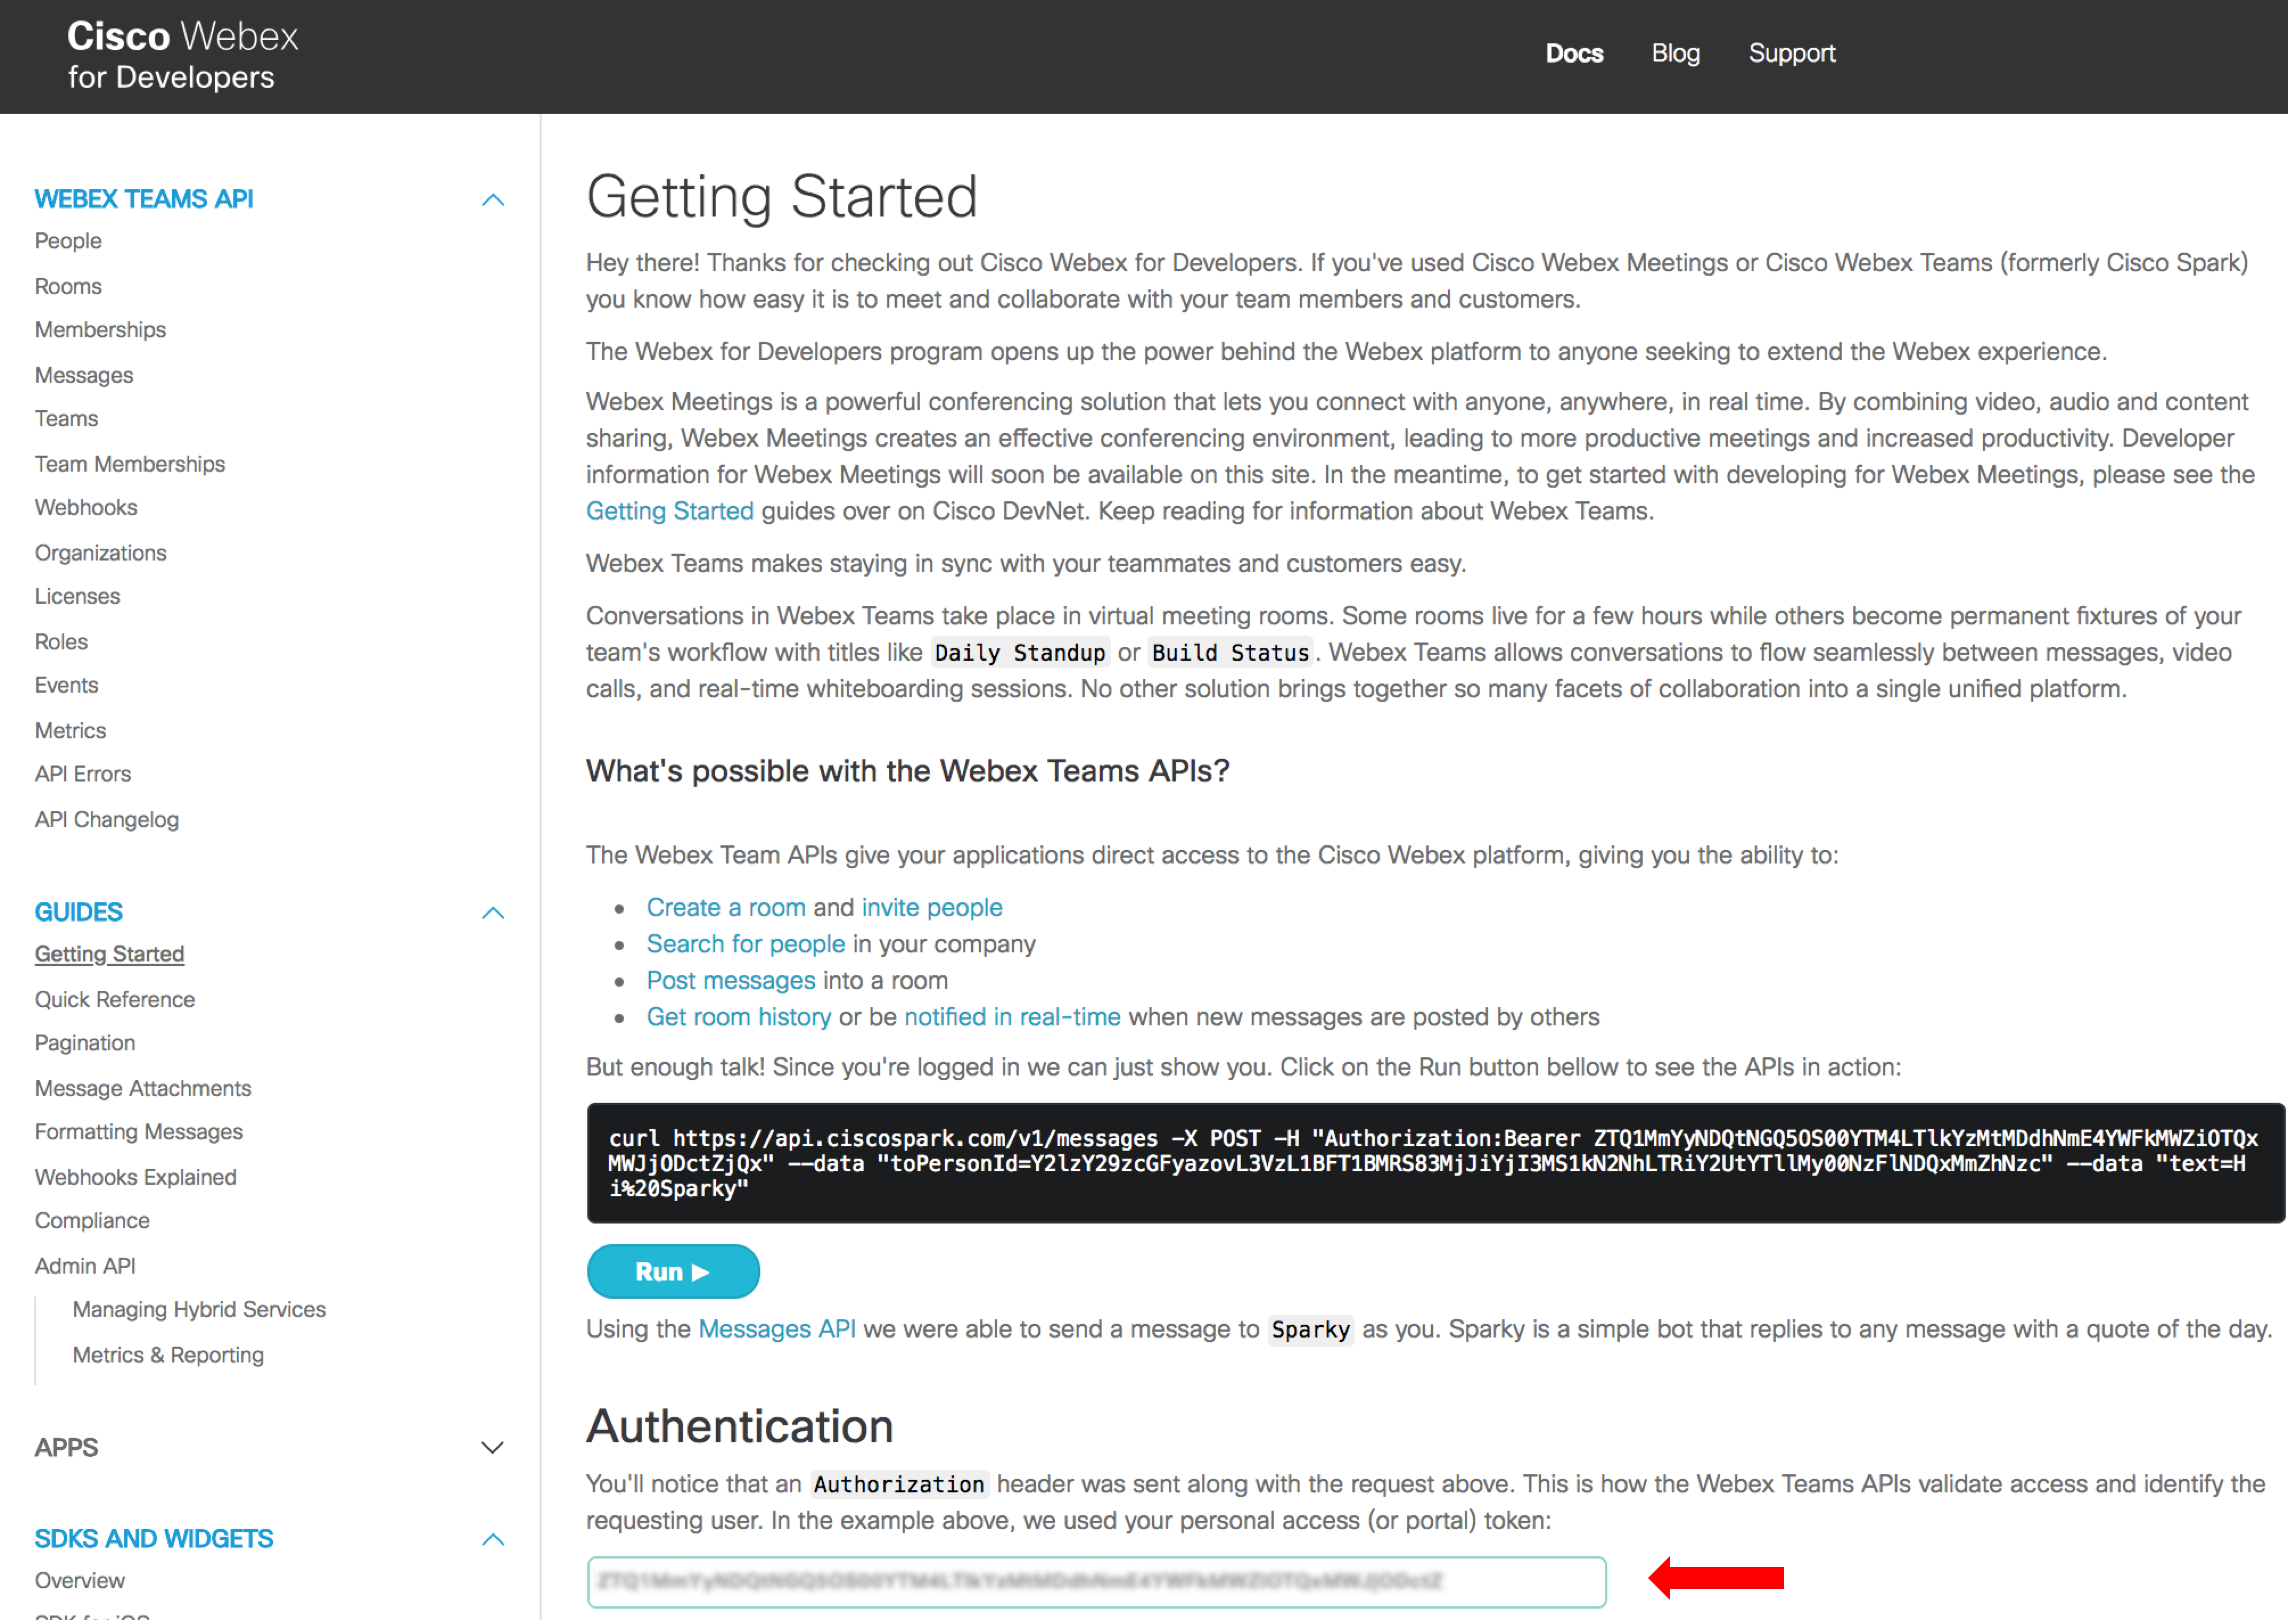

You can copy that token from there and insert it into the Python code below; you want to remove the *#* comment character to enable the assignment.

In [6]:
#access_token = 'OWU3ODk*****NWYwYjVhMGFhZDQ5OWMtZWFi'

# Using the Webex Teams APIs

## Getting a list of spaces

The endpoint to get a list of spaces is documented here: https://developer.webex.com/endpoint-rooms-get.html. Below is the code to get a list of all spaces.

In [7]:
import requests
import json

def get_spaces(max_spaces = 1000, spaces_type=''):
    url = 'https://api.ciscospark.com/v1/rooms'

    params = {
        'max': max_spaces, 
        'type' : spaces_type
    }

    # authorization is achieved by passing the access token in an authorization header
    headers = {'Authorization' : 'Bearer {}'.format(access_token),
              'Content-type' : 'application/json; charset=utf-8'}

    r = requests.get(url, params=params, headers=headers)

    # raise an exception in case the request failed
    r.raise_for_status()
    
    # use the json() method of the response object to get the response
    r = r.json()
    
    # the spaces are returned in the 'items' array of the response
    return r['items']


In [8]:

# get all spaces using the above function
spaces = get_spaces(max_spaces = 1000, spaces_type = 'group')

# create a sorted list of space titles starting with 'BRK'
titles = [s['title'] for s in spaces]
titles = [t for t in titles if t.startswith('BRKCOL-2175')]
titles.sort()

print('\n'.join(titles))

BRKCOL-2175Test


# Posting content to a space

The endpoint to post to a space is documented here: https://developer.webex.com/endpoint-messages-post.html. 

## Wrapper to post to a space

The simple wrapper below basically supports all parameters as described in the [API documentation](https://developer.ciscospark.com/endpoint-messages-post.html)

In [9]:
def post_message(roomId = None, toPersonId = None, toPersonEmail = None, text = None, markdown = None, files = None):
    params = {}
    
    # three different options to define destination
    if roomId is not None:
        params['roomId'] = roomId
    elif toPersonId is not None:
        params['toPersonId'] = toPersonId
    else:
        params['toPersonEmail'] = toPersonEmail
        
    # three different options to define the content
    if text is not None:
        params['text'] = text
    if markdown is not None:
        params['markdown'] = markdown
    if files is not None:
        params['files'] = files
    
    headers = {
        'Authorization' : 'Bearer {}'.format(access_token),
        'Content-Type' : 'application/json; charset=utf-8'
    }

    url = 'https://api.ciscospark.com/v1/messages'

    # the endpoint requires a POST and the parameters are passed as JSON in the body
    r = requests.post(url, json=params, headers=headers)
    
    return r.json()

## Posting Text to a 1:1 space

Now we can use the above simple wrapper to post text to a 1:1 space simply by providing an email address and the text to post.

In [10]:
import datetime

r = post_message(toPersonEmail = 'jkrohn@cisco.com', text = '{}: Test'.format(datetime.datetime.now()))
print(json.dumps(r, indent=4))

{
    "id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYTkyZjhmMTAtNmNlZi0xMWU4LTgwZjEtMTkwOGQyYzg3NmJi",
    "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vYTEyYzhjOTEtNDE0Yi0zNzAxLWJlYjUtMjNkNDgxNjEzOWQz",
    "toPersonEmail": "jkrohn@cisco.com",
    "roomType": "direct",
    "text": "2018-06-10 16:48:42.137926: Test",
    "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ",
    "personEmail": "jeokrohn@gmail.com",
    "created": "2018-06-10T20:48:42.625Z"
}


## Posting text to a group space

Posting to a regular group space requires the ID of the space to post to. This ID can be achieved by looking at the list of all spaces and searching for the space with the desired title

In [11]:
target_space_title = 'BRKCOL-2175T'

spaces = get_spaces(spaces_type='group')

# (s for s in spaces) defines a generator which will return all spaces one by one if next() is called for the generator
# (s for s in spaces if s['title'] == target_space_title) is a generator for all spaces where the title matches
# calling next() on that generator returns the 1st space which matches the criteria expressed by 'if' in the generator
spaces = (s for s in spaces if s['title'].startswith(target_space_title))
spaces = (s for s in spaces if s['created'][:7] > '2018-04')
target_space = next(spaces)

print('target_space: {}'.format(target_space))
target_space_id = target_space['id']

print('\nTarget space \'{}\' has id {}'.format(target_space['title'], target_space_id))

target_space: {'id': 'Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy', 'title': 'BRKCOL-2175Test', 'type': 'group', 'isLocked': False, 'lastActivity': '2018-06-06T09:15:16.299Z', 'creatorId': 'Y2lzY29zcGFyazovL3VzL1BFT1BMRS8wNzhkOGVjMi05Mjg5LTQ2NTUtOWE5NC0wNDNiOWVjMTMyOTk', 'created': '2018-05-09T12:12:27.167Z'}

Target space 'BRKCOL-2175Test' has id Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy


With that space ID we can now again post text using our wrapper.

In [12]:
import datetime

r = post_message(roomId = target_space_id, text = '{}: Test'.format(datetime.datetime.now()))
print(json.dumps(r, indent=4))

{
    "id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYjI2YmU4ODAtNmNlZi0xMWU4LTk1YTItZjU4MWM3OWM4YjE1",
    "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy",
    "roomType": "group",
    "text": "2018-06-10 16:48:57.686789: Test",
    "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ",
    "personEmail": "jeokrohn@gmail.com",
    "created": "2018-06-10T20:48:58.120Z"
}


## Formatting messages

Markdown can be used to post rich text content. The documentation of the available markdown syntax can be found at [developer.webex.com](https://developer.webex.com/formatting-messages.html) 

In [13]:
markdown = '''{}: Messages can contain [links](http://www.ciscolive.com/online).

And multiple lines of text.

**Bold** text is also possible.

Lists
- can
- contain
- multiple
- entries

Or
1. can
2. be
3. ordered
'''.format(datetime.datetime.now())
r = post_message(roomId = target_space_id, markdown = markdown)
print(json.dumps(r, indent=4))

{
    "id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYmExYTI3ZTAtNmNlZi0xMWU4LTg5N2QtM2Q1MTFjODE0ZGJm",
    "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy",
    "roomType": "group",
    "text": "2018-06-10 16:49:10.614665: Messages can contain links. And multiple lines of text. Bold text is also possible. Lists can contain multiple entries Or can be ordered",
    "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ",
    "personEmail": "jeokrohn@gmail.com",
    "markdown": "2018-06-10 16:49:10.614665: Messages can contain [links](http://www.ciscolive.com/online).\n\nAnd multiple lines of text.\n\n**Bold** text is also possible.\n\nLists\n- can\n- contain\n- multiple\n- entries\n\nOr\n1. can\n2. be\n3. ordered\n",
    "html": "<p>2018-06-10 16:49:10.614665: Messages can contain <a href=\"http://www.ciscolive.com/online\" rel=\"nofollow\">links</a>.</p><p>And multiple lines of text.</p><p><strong>Bold</strong> text 

## Posting Attachments

### Public Files

The API allows to pass a public URL of a file to be posted to Webex Teams as an attachment. 

In [14]:
# list of publicly accessible URLs of some traffic cams in Germany
urls = ['http://autobahn-rlp.de/syncdata/cam/380/thumb_640x480.jpg',
        'http://autobahn-rlp.de/syncdata/cam/385/thumb_640x480.jpg',
        'http://autobahn-rlp.de/syncdata/cam/165/thumb_640x480.jpg']

text = 'Traffic in Germany'

r = post_message(roomId = target_space_id, text=text)

# now for each traffic cam 
for url in urls:
    # post a message with one attachment defined by that public URL
    r = post_message(roomId = target_space_id, files=[url])


### Local Files

Obviously it is not possible to provide a publicly accessible URI for a local file to attach the local file to a Webex Teams message.

Thus to attach a local file to a Webex Teams message a different method needs to be used. The API also supports direct upload of a local file as described in this blog post: https://developer.webex.com/blog/blog-details-8129.html

Essentially in this case the parameters of the API calls are not passed as JSON in the body of the POST. Instead a multipart body is POSTed with each parameter passed in one part.

The [`requests_toolbelt`](https://pypi.python.org/pypi/requests-toolbelt) module is used to create the multipart MIME body.

This module can be installed via:
> pip install requests_toolbelt

This is how the body would look like:

```
--469c20fd02014a488c06beaf5bc7b275
Content-Disposition: form-data; name="files"; filename="Agenda"
Content-Type: application/pdf

%PDF-1.3\n%\xc4\xe5\xf2\xe5\xeb\xa7\xf3\xa0\xd0\xc4\xc6\n4 0 obj\n<< /Length 5 0 R /Filter /FlateDecode >>\
...
%%EOF

--469c20fd02014a488c06beaf5bc7b275
Content-Disposition: form-data; name="text"

Here is the agenda
--469c20fd02014a488c06beaf5bc7b275
Content-Disposition: form-data; name="roomId"

Y2lzY29zcGFyazovL3VzL1JPT00vM2Q3MjE0ODAtNDA3NC0xMWU3LTk3MDgtMGRmOWNkNzFjNWQx
--469c20fd02014a488c06beaf5bc7b275--

```

The Content-Type header of the POST in this case would be:
```
Content-Type: multipart/form-data; boundary=469c20fd02014a488c06beaf5bc7b275
```


In [15]:
import requests_toolbelt
import requests

file_path = './BRKCOL-2175_Agenda.pdf'
file_type = 'application/pdf'
endpoint = "https://api.ciscospark.com/v1/messages"

with open(file_path, 'rb') as f:
    # prepare the multipart body
    data = {'roomId': target_space_id, 
            'text': 'Here is the agenda',
            'files': ('Agenda', f, file_type)
           }
    multi_part = requests_toolbelt.MultipartEncoder(fields=data)
    
    headers = {'Content-Type': multi_part.content_type,
            'Authorization': 'Bearer {}'.format(access_token)}
    
    r = requests.post(endpoint, data=multi_part, headers=headers)

r.raise_for_status()

print(json.dumps(r.json(), indent=4))

print('\nThe request has been sent with\n\'Content-Type: {}\''.format(r.request.headers['Content-Type']))


{
    "id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzJiN2Y3NjAtNmNlZi0xMWU4LTk0YmQtOTU3ZDkwNjYyYTA2",
    "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy",
    "roomType": "group",
    "text": "Here is the agenda",
    "files": [
        "https://api.ciscospark.com/v1/contents/Y2lzY29zcGFyazovL3VzL0NPTlRFTlQvYzJiN2Y3NjAtNmNlZi0xMWU4LTk0YmQtOTU3ZDkwNjYyYTA2LzA"
    ],
    "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ",
    "personEmail": "jeokrohn@gmail.com",
    "created": "2018-06-10T20:49:25.462Z"
}

The request has been sent with
'Content-Type: multipart/form-data; boundary=b5442713e7da4f7fb3aa47aae58c4e8c'


# Simplify Webex Teams API usage by using an API wrapper

While creating wrappers for all methods offered by the [Webex Teams API](https://developer.webex.com/getting-started.html) is pretty straight forward (see the `post_message()` and `get_spaces()` examples above) it's even easier (and more efficient) to use a readily available API wrapper which supports all operations offered by the Webex Teams API. 

One example is the [ciscosparkapi](https://github.com/CiscoDevNet/ciscosparkapi) API wrapper. It can be installed via:
> `pip install ciscosparkapi` 

Documentation is hosted at http://ciscosparkapi.readthedocs.io/en/latest/index.html


## Create the API object

The **`CiscoSparkAPI`** object is instantiated with the existing OAuth access token which will then be used for all API calls by the wrapper.

In [16]:
import ciscosparkapi

api = ciscosparkapi.CiscoSparkAPI(access_token=access_token)


## Find a space

The target space for our tests again can be found by going through the list of spaces and looking for the right title. The API wrapper instead of returning JSON (or Python dictionaries as in our examples above) returns objects. For example the elements returned by the generator created by the [`rooms.list()`](http://ciscosparkapi.readthedocs.io/en/latest/user/api.html#rooms) call are [Room](http://ciscosparkapi.readthedocs.io/en/latest/user/api.html#room) objects so that we have to look at the `.title` attribute instead of looking at the `['title']` member of a dictionary.

In [17]:
import ciscosparkapi

api = ciscosparkapi.CiscoSparkAPI(access_token=access_token)

spaces = api.rooms.list(max=500, type='group')
# we rely on the fact that the newest space comes first in the list
target_space = next((s for s in spaces if s.title.startswith(target_space_title)))
target_space

Room({"id": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy", "title": "BRKCOL-2175Test", "type": "group", "isLocked": false, "lastActivity": "2018-06-10T20:49:25.462Z", "creatorId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS8wNzhkOGVjMi05Mjg5LTQ2NTUtOWE5NC0wNDNiOWVjMTMyOTk", "created": "2018-05-09T12:12:27.167Z"})

## Iterate through messages

The Wrapper also allows to easily iterate through all messages posted in a given space.

In [18]:
import ciscosparkapi

api = ciscosparkapi.CiscoSparkAPI(access_token=access_token)

messages = api.messages.list(roomId=target_space.id, max=1000)
for m in messages:
    print(m)

Message:
{
  "id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzJiN2Y3NjAtNmNlZi0xMWU4LTk0YmQtOTU3ZDkwNjYyYTA2",
  "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy",
  "roomType": "group",
  "text": "Here is the agenda",
  "files": [
    "https://api.ciscospark.com/v1/contents/Y2lzY29zcGFyazovL3VzL0NPTlRFTlQvYzJiN2Y3NjAtNmNlZi0xMWU4LTk0YmQtOTU3ZDkwNjYyYTA2LzA"
  ],
  "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ",
  "personEmail": "jeokrohn@gmail.com",
  "created": "2018-06-10T20:49:25.462Z"
}
Message:
{
  "id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzFjODE5MjAtNmNlZi0xMWU4LTg1NTAtNmIxZWNhMDFiYjAw",
  "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy",
  "roomType": "group",
  "files": [
    "https://api.ciscospark.com/v1/contents/Y2lzY29zcGFyazovL3VzL0NPTlRFTlQvYzFjODE5MjAtNmNlZi0xMWU4LTg1NTAtNmIxZWNhMDFiYjAwLzA"
  ],
  "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00N

## Filtering messages (messages posted by me)

Using the same mechanisms as above we can easily filter for messages posted by ourself by looking at the `personId` of the messages in the space.

In [19]:
import ciscosparkapi

api = ciscosparkapi.CiscoSparkAPI(access_token=access_token)

me = api.people.me()

messages = api.messages.list(roomId=target_space.id, max=2000)

messages_posted_by_me = [m for m in messages if m.personId == me.id]

print('{} messages posted by me'.format(len(messages_posted_by_me)))

messages_posted_by_me

7 messages posted by me


[Message({"id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzJiN2Y3NjAtNmNlZi0xMWU4LTk0YmQtOTU3ZDkwNjYyYTA2", "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy", "roomType": "group", "text": "Here is the agenda", "files": ["https://api.ciscospark.com/v1/contents/Y2lzY29zcGFyazovL3VzL0NPTlRFTlQvYzJiN2Y3NjAtNmNlZi0xMWU4LTk0YmQtOTU3ZDkwNjYyYTA2LzA"], "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ", "personEmail": "jeokrohn@gmail.com", "created": "2018-06-10T20:49:25.462Z"}),
 Message({"id": "Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzFjODE5MjAtNmNlZi0xMWU4LTg1NTAtNmIxZWNhMDFiYjAw", "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy", "roomType": "group", "files": ["https://api.ciscospark.com/v1/contents/Y2lzY29zcGFyazovL3VzL0NPTlRFTlQvYzFjODE5MjAtNmNlZi0xMWU4LTg1NTAtNmIxZWNhMDFiYjAwLzA"], "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ", "perso

## Creating messages

The API wrapper also supports greating messages. When creating messages with attachments (`files` parameter is used) then the API makes sure to use multipart messages to upload if a local file is referenced in the `files` argument.


In [20]:
import ciscosparkapi

api = ciscosparkapi.CiscoSparkAPI(access_token=access_token)

api.messages.create(roomId=target_space.id, text='Posted via the ciscosparkapi API')

api.messages.create(roomId=target_space.id, text='Posted via the ciscosparkapi API', markdown='Posted via the **`ciscosparkapi`** API')

files = ['http://autobahn-rlp.de/syncdata/cam/380/thumb_640x480.jpg',
         'http://autobahn-rlp.de/syncdata/cam/385/thumb_640x480.jpg',
         'http://autobahn-rlp.de/syncdata/cam/165/thumb_640x480.jpg',
         './BRKCOL-2175_Agenda.pdf']

me = api.people.me()
print(me)

api.messages.create(roomId=target_space.id, text='Some attachments')
# need to post the attachments individually as the Webex Teams API currently only supports one attachment at a time.
for file in files:
    api.messages.create(roomId=target_space.id, 
                        markdown='Posted by <@personId:{id}|{display}>'.format(id=me.id, display=me.displayName), 
                        files=[file])

Person:
{
  "id": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ",
  "emails": [
    "jeokrohn@gmail.com"
  ],
  "displayName": "Johannes Krohn (gmail)",
  "nickName": "Johannes",
  "orgId": "Y2lzY29zcGFyazovL3VzL09SR0FOSVpBVElPTi9jb25zdW1lcg",
  "created": "2016-12-13T15:29:02.788Z",
  "lastActivity": "2018-06-10T20:49:36.407Z",
  "status": "active",
  "type": "person"
}


## Looking at memberships

The memberships API app allows to read, or update Webex Teams space memberships. 

In [21]:
import ciscosparkapi
import base64

api = ciscosparkapi.CiscoSparkAPI(access_token=access_token)

members = api.memberships.list(roomId=target_space.id)
for m in members:
    print(m)


Membership:
{
  "id": "Y2lzY29zcGFyazovL3VzL01FTUJFUlNISVAvMDc4ZDhlYzItOTI4OS00NjU1LTlhOTQtMDQzYjllYzEzMjk5OjNkMjdjMmYwLTUzODItMTFlOC1iMWVhLWJmZTc3MTVlMzM2Mg",
  "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy",
  "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS8wNzhkOGVjMi05Mjg5LTQ2NTUtOWE5NC0wNDNiOWVjMTMyOTk",
  "personEmail": "jkrohn@cisco.com",
  "personDisplayName": "Johannes Krohn",
  "personOrgId": "Y2lzY29zcGFyazovL3VzL09SR0FOSVpBVElPTi8xZWI2NWZkZi05NjQzLTQxN2YtOTk3NC1hZDcyY2FlMGUxMGY",
  "isModerator": false,
  "isMonitor": false,
  "created": "2018-05-09T12:12:27.770Z"
}
Membership:
{
  "id": "Y2lzY29zcGFyazovL3VzL01FTUJFUlNISVAvODI3OWU5ODAtNDVlYi00ZTBlLWI5MWMtYThhMDgzMDUxMTM0OjNkMjdjMmYwLTUzODItMTFlOC1iMWVhLWJmZTc3MTVlMzM2Mg",
  "roomId": "Y2lzY29zcGFyazovL3VzL1JPT00vM2QyN2MyZjAtNTM4Mi0xMWU4LWIxZWEtYmZlNzcxNWUzMzYy",
  "personId": "Y2lzY29zcGFyazovL3VzL1BFT1BMRS84Mjc5ZTk4MC00NWViLTRlMGUtYjkxYy1hOGEwODMwNTExMzQ",
  "personEmail": "jeokrohn@g

## Bulk deleting messages
With the list of messages posted by me we can easily delete all messages created by me

# !!!BE CAREFUL WITH THIS CODE!!!
# !!!MAKE SURE (TRIPPLE CHECK) TO USE A TEST SPACE ONLY!!!

In [22]:
import ciscosparkapi

api = ciscosparkapi.CiscoSparkAPI(access_token=access_token)

me = api.people.me()

# list of message IDs posted by me in the above space
my_message_ids = [m.id for m in api.messages.list(roomId=target_space.id) if m.personId == me.id]

print('Deleting {} messsages'.format(len(my_message_ids)))

# enumerate() returns an iterator which returns tuples (index, element of iterable passed to enumerate)
# reversed() created an iterator which returs elements of the passed list in reversed order
# using reversed() as we want to delete the messages in chronological order: oldest 1st
for i, id in enumerate(my_message_ids):
    print('Deleting message {}/{}'.format(i+1, id))
    api.messages.delete(id)

Deleting 14 messsages
Deleting message 1/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvZDliNjMyNjAtNmNlZi0xMWU4LWEyYmMtMGZhY2JjZWQ1Mjdl
Deleting message 2/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvZDg3ZWVhZTAtNmNlZi0xMWU4LTk4MTktMGY3MTZkNjhlN2Ex
Deleting message 3/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvZDY3ZjIzNDAtNmNlZi0xMWU4LWJkZjEtMjNkYTVkODU0NDc5
Deleting message 4/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvZDQ5NDFjMjAtNmNlZi0xMWU4LTk1YTItZjU4MWM3OWM4YjE1
Deleting message 5/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvZDI3MjliYjAtNmNlZi0xMWU4LTgzOWUtM2I0YTRlNjQ1NDcz
Deleting message 6/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvZDI1MzA1YzAtNmNlZi0xMWU4LWE2OWEtNzcwZGZjOTEzMjQy
Deleting message 7/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvZDIzYjEwZjAtNmNlZi0xMWU4LTgzM2QtNDE3NmMzYTk2Zjc2
Deleting message 8/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzJiN2Y3NjAtNmNlZi0xMWU4LTk0YmQtOTU3ZDkwNjYyYTA2
Deleting message 9/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzFjODE5MjAtNmNlZi0xMWU4LTg1NTAtNmIxZWNhMDFiYjAw
Deleting message 10/Y2lzY29zcGFyazovL3VzL01FU1NBR0UvYzA2NmRiNzAtNmNlZi0xMWU4LT